[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/17_paper.cnn.train_eval.ipynb)

# 4.3. Train & evaluate (CNN)

> Train & evaluate on multiple train/test splits with different random seeds

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Python utilities
from pathlib import Path
import pickle

# Data science stack
import pandas as pd

from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import log_transform_y
from mirzai.data.torch import DataLoaders, SNV_transform
from mirzai.training.cnn import (Model, weights_init)
from mirzai.training.cnn import Learner, Learners
from mirzai.training.core import load_dumps

# Deep Learning stack
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from torch.optim.lr_scheduler import CyclicLR

from fastcore.transform import compose

import warnings
warnings.filterwarnings('ignore')

## 1. Load and transform

### Load data

In [ ]:
# For testing purpose
#src_dir = 'test'
#fnames = ['spectra-features-smp.npy', 'spectra-wavenumbers-smp.npy', 
#          'depth-order-smp.npy', 'target-smp.npy', 
#          'tax-order-lu-smp.pkl', 'spectra-id-smp.npy']


# or with all data
src_dir = '/content/drive/MyDrive/research/predict-k-mirs-dl/data/potassium'
fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)
data = X, y, X_id, depth_order
transforms = [select_y, select_tax_order, select_X, log_transform_y]
X, y, X_id, depth_order = compose(*transforms)(data)

## Experiment

### Setup

In [ ]:
# Is a GPU available?
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'Runtime is: {device}')

params_scheduler = {
    'base_lr': 3e-5,
    'max_lr': 1e-3,
    'step_size_up': 5,
    'mode': 'triangular',
    'cycle_momentum': False
}

n_epochs = 201
seeds = range(20)
seeds = range(15, 20)

Runtime is: cuda:0


### Train on all Soil Taxonomic Orders 

In [ ]:
# Replace following Paths with yours
dest_dir_loss = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/losses')
dest_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')

learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
learners.train((X, y, depth_order[:, -1]), 
               dest_dir_loss=dest_dir_loss,
               dest_dir_model=dest_dir_model,
               n_epochs=n_epochs,
               sc_kwargs=params_scheduler)

--------------------------------------------------------------------------------
Seed: 15
--------------------------------------------------------------------------------
------------------------------
Epoch: 0
Training loss: 0.21006273476802928 | Validation loss: 0.16685934806555774
Validation loss (ends of cycles): [0.16685935]
------------------------------
Epoch: 1
Training loss: 0.10366790779631614 | Validation loss: 0.12193218717532875
Validation loss (ends of cycles): [0.16685935]
------------------------------
Epoch: 2
Training loss: 0.08515885396031883 | Validation loss: 0.07348759699843627
Validation loss (ends of cycles): [0.16685935]
------------------------------
Epoch: 3
Training loss: 0.07681338573754655 | Validation loss: 0.0775093322174739
Validation loss (ends of cycles): [0.16685935]
------------------------------
Epoch: 4
Training loss: 0.07012089212630385 | Validation loss: 0.06804058407392122
Validation loss (ends of cycles): [0.16685935]
-------------------------

#### Evaluate on all

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')
seeds = range(20)
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_global_all, y_hats_all, y_trues_all, ns_all = learners.evaluate((X, y, depth_order[:, -1]),
                                                                      src_dir_model=src_dir_model)

In [ ]:
print(f'# of test samples: {ns_all.mean().item()}')

# of test samples: 4032.0


In [ ]:
# Save spectific seed y_hat, y_true to plot "Observed vs. predicted" scatterplots
# Replace following Paths with yours
dest_dir_predicted = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/')
seed = 1
with open(dest_dir_predicted/f'predicted-true-cnn-seed-{seed}.pickle', 'wb') as f: 
    pickle.dump((y_hats_all[seed].to_numpy(), y_trues_all[seed].to_numpy()), f)

In [ ]:
perfs_global_all.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.184830,2.992808,0.790243,0.884580,0.595624,0.377839,0.237318,30.946025,0.004749,0.009024
std,0.041494,0.067646,0.007929,0.004986,0.155836,0.259428,0.012061,0.932127,0.012705,0.024443
min,2.114635,2.889447,0.776315,0.874575,0.459073,0.210748,0.221478,29.163000,-0.012504,-0.024802
25%,2.159791,2.930840,0.785559,0.881369,0.504516,0.254547,0.225294,30.303971,-0.005159,-0.010186
50%,2.183314,3.015281,0.790165,0.884643,0.571964,0.327175,0.236342,30.827668,0.004057,0.007958
75%,2.205628,3.028623,0.794389,0.887016,0.617017,0.380868,0.246811,31.663001,0.016258,0.031279
max,2.262492,3.141478,0.804596,0.895479,1.197708,1.434504,0.260846,32.642108,0.032962,0.062948


#### Evaluate on Soil Tax. Orders

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')
seeds = range(20)

for k, v in tax_lookup.items():
    print(80*'-')
    print(f'Test metrics on {k}')
    print(80*'-')
    learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
    perfs_global, _, _, ns = learners.evaluate((X, y, depth_order[:, -1]),
                                               order=v,
                                               src_dir_model=src_dir_model)

    print(f'# of test samples: {ns.mean().item()}')
    print(perfs_global.describe())

--------------------------------------------------------------------------------
Test metrics on alfisols
--------------------------------------------------------------------------------
# of test samples: 422.4
             rpd       rpiq         r2       lccc       rmse        mse  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    1.809327   2.462286   0.691663   0.822509   0.382106   0.174798   
std     0.087705   0.182733   0.030946   0.018080   0.174094   0.157874   
min     1.602639   2.154843   0.609675   0.773057   0.150495   0.022649   
25%     1.752131   2.328294   0.673422   0.810919   0.233184   0.054400   
50%     1.814577   2.449380   0.695557   0.823634   0.371884   0.138515   
75%     1.875471   2.573424   0.715007   0.835819   0.459433   0.211082   
max     1.949812   2.768350   0.736324   0.847946   0.794326   0.630953   

             mae       mape       bias        stb  
count  20.000000  20.000000  20.000000  20.000000  
mean    

#### Evaluate on Mollisols

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')
seeds = range(20)
order = 1
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_global_mollisols, _, _, _ = learners.evaluate((X, y, depth_order[:, -1]),
                                                    order=order,
                                                    src_dir_model=src_dir_model)

perfs_global_mollisols.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.082906,2.750063,0.767633,0.868226,0.441974,0.200178,0.217482,27.362061,0.006410,0.014927
std,0.105370,0.152068,0.022648,0.014038,0.071353,0.074478,0.011783,1.171648,0.014516,0.034156
min,1.910614,2.503716,0.725773,0.839147,0.351621,0.123637,0.198063,25.863001,-0.017837,-0.042497
25%,2.016213,2.645241,0.753751,0.858901,0.398954,0.159184,0.208970,26.442070,-0.002144,-0.005110
50%,2.073633,2.727649,0.767201,0.867132,0.434792,0.189089,0.217809,27.306423,0.006673,0.016067
75%,2.158195,2.803545,0.785071,0.877551,0.462096,0.213538,0.226259,27.765553,0.015423,0.036009
max,2.297545,3.113704,0.810361,0.892300,0.693749,0.481287,0.238283,30.162075,0.034060,0.082286


#### Evaluate on Gelisols

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')
seeds = range(20)
order = 12
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_global_gelisols, _, _, _ = learners.evaluate((X, y, depth_order[:, -1]),
                                                   order = order,
                                                   src_dir_model=src_dir_model)

perfs_global_gelisols.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2.064524,3.052019,0.742612,0.858711,0.584043,0.357354,0.308433,47.883342,-0.042954,-0.072261
std,0.339669,0.922599,0.076703,0.045312,0.131164,0.160157,0.061630,10.194859,0.037772,0.075571
min,1.563934,1.337414,0.579469,0.746647,0.378497,0.143260,0.194099,31.988180,-0.094267,-0.236790
25%,1.848496,2.458523,0.699683,0.841321,0.499613,0.249631,0.266246,38.717125,-0.076805,-0.105620
50%,2.025773,2.948530,0.749510,0.854638,0.568492,0.323183,0.303302,51.015234,-0.042409,-0.066190
75%,2.215420,3.613597,0.791696,0.889089,0.680335,0.464308,0.360686,55.561434,-0.021409,-0.028615
max,3.023628,4.793782,0.888340,0.943058,0.834707,0.696736,0.404708,60.821658,0.054468,0.089767


#### Evaluate on Vertisols

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')
seeds = range(20)
order = 10
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_global_vertisols, _, _, _ = learners.evaluate((X, y, depth_order[:, -1]),
                                                   order = order,
                                                   src_dir_model=src_dir_model)

perfs_global_vertisols.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.039982,2.815862,0.744782,0.856862,0.273233,0.078001,0.173488,26.855653,-0.001182,-0.003823
std,0.271953,0.511288,0.063033,0.036968,0.059333,0.036126,0.021406,3.272256,0.020647,0.055384
min,1.577848,2.128196,0.592591,0.768764,0.182002,0.033125,0.138288,21.111539,-0.052648,-0.154459
25%,1.851439,2.431125,0.703943,0.837489,0.232396,0.054013,0.157317,24.537946,-0.011511,-0.028144
50%,1.992414,2.714563,0.744894,0.855618,0.253052,0.064036,0.173311,26.192354,-0.001295,-0.003575
75%,2.178701,3.148894,0.786316,0.881447,0.303549,0.092144,0.188509,28.037003,0.009025,0.019823
max,2.713312,4.022168,0.862141,0.923391,0.427089,0.182405,0.208709,33.903363,0.040271,0.099009


### Train and test on Mollisols

In [ ]:
# Replace following Paths with yours
dest_dir_loss = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/mollisols/losses')
dest_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/mollisols/models')

order = 1
seeds = range(20)
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
learners.train((X, y, depth_order[:, -1]), 
               order=order,
               dest_dir_loss=dest_dir_loss,
               dest_dir_model=dest_dir_model,
               n_epochs=n_epochs,
               sc_kwargs=params_scheduler)

Streaming output truncated to the last 5000 lines.
 0.0254631  0.02506297 0.02542974]
------------------------------
Epoch: 148
Training loss: 0.01703691177108154 | Validation loss: 0.03745046781440233
Validation loss (ends of cycles): [0.09721728 0.04142509 0.03426372 0.03054056 0.02912892 0.02823934
 0.02746296 0.02677113 0.02637389 0.02613157 0.02631584 0.02581771
 0.0254631  0.02506297 0.02542974]
------------------------------
Epoch: 149
Training loss: 0.01636921336912379 | Validation loss: 0.029602385222398
Validation loss (ends of cycles): [0.09721728 0.04142509 0.03426372 0.03054056 0.02912892 0.02823934
 0.02746296 0.02677113 0.02637389 0.02613157 0.02631584 0.02581771
 0.0254631  0.02506297 0.02542974]
------------------------------
Epoch: 150
Training loss: 0.01618192989227115 | Validation loss: 0.02575919661542465
Validation loss (ends of cycles): [0.09721728 0.04142509 0.03426372 0.03054056 0.02912892 0.02823934
 0.02746296 0.02677113 0.02637389 0.02613157 0.02631584 0.025

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/mollisols/models')
seeds = range(20)
order = 1
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_local_mollisols, _, _, _ = learners.evaluate((X, y, depth_order[:, -1]),
                                                   order = order,
                                                   src_dir_model=src_dir_model)

perfs_local_mollisols.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.103741,2.777945,0.772714,0.873048,0.454543,0.212442,0.214790,26.963759,0.008362,0.019571
std,0.085642,0.136850,0.019085,0.011321,0.078355,0.080627,0.010765,1.352271,0.013197,0.031140
min,1.923080,2.550751,0.729316,0.846127,0.360252,0.129782,0.200901,25.281143,-0.008894,-0.021487
25%,2.058124,2.688481,0.763672,0.865870,0.408399,0.166824,0.206547,25.622950,-0.004228,-0.009841
50%,2.111893,2.778513,0.775535,0.873508,0.428046,0.183224,0.212339,27.126652,0.009768,0.022086
75%,2.166518,2.872471,0.786733,0.881705,0.470035,0.220976,0.221762,27.655639,0.017485,0.041642
max,2.256515,3.048478,0.803395,0.891445,0.664916,0.442113,0.240433,30.713740,0.039076,0.092671


### Train and test on Gelisols

In [ ]:
# Replace following Paths with yours
dest_dir_loss = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/gelisols/losses')
dest_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/gelisols/models')

order = 12
seeds = range(20) 
n_epochs = 31
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
learners.train((X, y, depth_order[:, -1]), 
               order=order,
               dest_dir_loss=dest_dir_loss,
               dest_dir_model=dest_dir_model,
               n_epochs=n_epochs,
               sc_kwargs=params_scheduler)

--------------------------------------------------------------------------------
Seed: 0
--------------------------------------------------------------------------------
------------------------------
Epoch: 0
Training loss: 0.44518339904871856 | Validation loss: 0.41080141067504883
Validation loss (ends of cycles): [0.41080141]
------------------------------
Epoch: 1
Training loss: 0.4287309023466977 | Validation loss: 0.4031795859336853
Validation loss (ends of cycles): [0.41080141]
------------------------------
Epoch: 2
Training loss: 0.4021740339019082 | Validation loss: 0.3900226950645447
Validation loss (ends of cycles): [0.41080141]
------------------------------
Epoch: 3
Training loss: 0.37238084186207165 | Validation loss: 0.37106457352638245
Validation loss (ends of cycles): [0.41080141]
------------------------------
Epoch: 4
Training loss: 0.3336567445234819 | Validation loss: 0.3466283082962036
Validation loss (ends of cycles): [0.41080141]
------------------------------


In [ ]:
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/gelisols/models')
order = 12
seeds = range(20)
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_local_gelisols, _, _, _ = learners.evaluate((X, y, depth_order[:, -1]),
                                                  order = order,
                                                  src_dir_model=src_dir_model)

perfs_local_gelisols.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,1.887493,2.754606,0.691143,0.805993,0.657956,0.461482,0.346751,51.508686,-0.009657,-0.016915
std,0.330355,0.728265,0.088094,0.057573,0.173942,0.263369,0.094363,12.377707,0.048598,0.078858
min,1.547348,1.282034,0.572637,0.714614,0.376275,0.141583,0.181809,34.942499,-0.114649,-0.215123
25%,1.642766,2.256554,0.619215,0.753152,0.574179,0.329684,0.303541,43.296409,-0.029528,-0.041320
50%,1.817055,2.608120,0.690513,0.805246,0.617902,0.381848,0.335921,47.255385,-0.001811,-0.002683
75%,2.033550,3.186851,0.752098,0.844316,0.728023,0.530550,0.386050,61.034292,0.016324,0.030791
max,2.791070,4.049294,0.867742,0.920004,1.118009,1.249944,0.565283,73.572367,0.079008,0.092876


### Train and test on Vertisols

In [ ]:
# Replace following Paths with yours
dest_dir_loss = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/vertisols/losses')
dest_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/vertisols/models')

order = 10
seeds = range(20) 
n_epochs = 31
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
learners.train((X, y, depth_order[:, -1]), 
               order=order,
               dest_dir_loss=dest_dir_loss,
               dest_dir_model=dest_dir_model,
               n_epochs=n_epochs,
               sc_kwargs=params_scheduler)

--------------------------------------------------------------------------------
Seed: 0
--------------------------------------------------------------------------------
------------------------------
Epoch: 0
Training loss: 0.161204216511626 | Validation loss: 0.1679159700870514
Validation loss (ends of cycles): [0.16791597]
------------------------------
Epoch: 1
Training loss: 0.15437143099935433 | Validation loss: 0.15762153267860413
Validation loss (ends of cycles): [0.16791597]
------------------------------
Epoch: 2
Training loss: 0.13889641942162262 | Validation loss: 0.13728273659944534
Validation loss (ends of cycles): [0.16791597]
------------------------------
Epoch: 3
Training loss: 0.11834369207683362 | Validation loss: 0.10279234126210213
Validation loss (ends of cycles): [0.16791597]
------------------------------
Epoch: 4
Training loss: 0.09297808573434227 | Validation loss: 0.09408992528915405
Validation loss (ends of cycles): [0.16791597]
----------------------------

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/vertisols/models')
order = 10
seeds = range(20)
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_local_vertisols, _, _, _ = learners.evaluate((X, y, depth_order[:, -1]),
                                                  order = order,
                                                  src_dir_model=src_dir_model)

perfs_local_vertisols.describe()

,rpd,rpiq,r2,lccc,rmse,mse,mae,mape,bias,stb
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1.777816,2.448334,0.669128,0.800569,0.328906,0.110845,0.213575,30.958227,-0.001265,-0.003632
std,0.184440,0.352951,0.069418,0.041342,0.052977,0.037720,0.023262,4.237755,0.024421,0.065963
min,1.473109,1.825536,0.532598,0.716435,0.252563,0.063788,0.179316,24.304497,-0.041362,-0.115813
25%,1.615667,2.245532,0.611233,0.773600,0.292217,0.085391,0.197175,28.024661,-0.016770,-0.041078
50%,1.788574,2.443511,0.683310,0.807425,0.318792,0.101629,0.209331,29.388569,0.000355,0.000905
75%,1.925041,2.621849,0.726185,0.828116,0.349539,0.122219,0.231883,34.220246,0.018196,0.041607
max,2.113319,3.132748,0.772750,0.861943,0.458266,0.210007,0.255553,40.589359,0.043430,0.129690


### Checking losses

In [ ]:
from mirzai.training.core import load_dumps

# Replace following Paths with yours
dest_dir_loss = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/vertisols/losses')
losses = load_dumps(dest_dir_loss)

<AxesSubplot:>

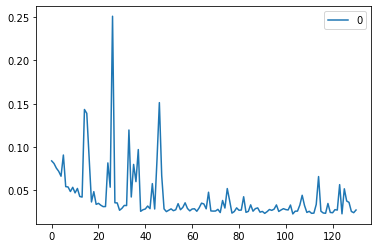

In [ ]:
pd.DataFrame(losses[4]['valid']).plot()

### Compile metrics for "local vs. global" Fig. 6

In [ ]:
def format_metrics(*dfs):
    perfs = {'r2': {'mean': [], 'std': []},
             'mape': {'mean': [], 'std': []}}
    for df in dfs:
        for metric in ['r2', 'mape']:
            mean, std = df.describe().loc[['mean', 'std'], metric].items()
            perfs[metric]['mean'].append(mean[1])
            perfs[metric]['std'].append(std[1])
    return perfs

In [ ]:
perfs = {}
perfs['global'] = format_metrics(perfs_global_mollisols, perfs_global_gelisols, perfs_global_vertisols)
perfs['local'] = format_metrics(perfs_local_mollisols, perfs_local_gelisols, perfs_local_vertisols)

In [ ]:
perfs

{'global': {'r2': {'mean': [0.7676331517935623,
    0.7426116984444495,
    0.7447822285232857],
   'std': [0.022648288190552323, 0.0767026908137805, 0.06303329177546012]},
  'mape': {'mean': [27.362060844898224, 47.88334220647812, 26.8556547164917],
   'std': [1.1716483447190629, 10.194857908308927, 3.2722567422732105]}},
 'local': {'r2': {'mean': [0.7727136496500038,
    0.7461132281184896,
    0.7569868331639625],
   'std': [0.01908464680719597, 0.08643306096790201, 0.05496486944699407]},
  'mape': {'mean': [26.96375846862793, 43.78511905670166, 25.207100808620453],
   'std': [1.352271118990351, 10.660068154956656, 2.427168862994315]}}}

In [ ]:
dest_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn')
with open(dest_dir/'global_vs_local.pickle', 'wb') as f:
    pickle.dump(perfs, f)
